In [1]:

import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print(torchvision.__version__)

Random Seed:  999
0.2.1


In [2]:
# This cell is only for Google Colaboratory
#from google.colab import drive
#drive.mount('/content/gdrive')

path1 = "train_images" # Fake generated images here
path2 = "gen"   # Generator parameters path
path3 = "dis"   # Discriminator parameters path

In [3]:
# Root directory for dataset
dataroot = "Art/Uusi_Kansio"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3 # with mnist 1, other 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
max_epoch = 800 # need more than 20 epochs for training generator

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of labels
num_labels = 2 # we will use 4, CIFAR and MNIST has 10

In [4]:
# Define which device you use for calculation. If you can use cuda, this will automatically use it. Otherwise cpu is automatically used.

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [5]:
'''
This is a multiline
comment.

transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(image_size),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.5,0.5,0.5), (0.5,0.5,0.5))])

dataset =  torchvision.datasets.CIFAR10('/files/', train=True, download=True, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
'''

'\nThis is a multiline\ncomment.\n\ntransform=torchvision.transforms.Compose([\n                                 torchvision.transforms.Resize(image_size),\n                                 torchvision.transforms.ToTensor(),\n                                 torchvision.transforms.Normalize(\n                                 (0.5,0.5,0.5), (0.5,0.5,0.5))])\n\ndataset =  torchvision.datasets.CIFAR10(\'/files/\', train=True, download=True, transform = transform)\n\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)\n\nreal_batch = next(iter(data_loader))\nplt.figure(figsize=(8,8))\nplt.axis("off")\nplt.title("Training Images")\nplt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))\n'

In [6]:
dataroot = []
dataset = []
# Create new dataset from images
for i in range(1,num_labels + 1):
    dataset.append(dset.ImageFolder(root=F"./Dog_images/Label{i}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

# Create labels for our dataset
# Labels are in i
print(len(dataset))
print(len(dataset[0]))
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
newdataset = torch.utils.data.ConcatDataset(dataset)

2
13800


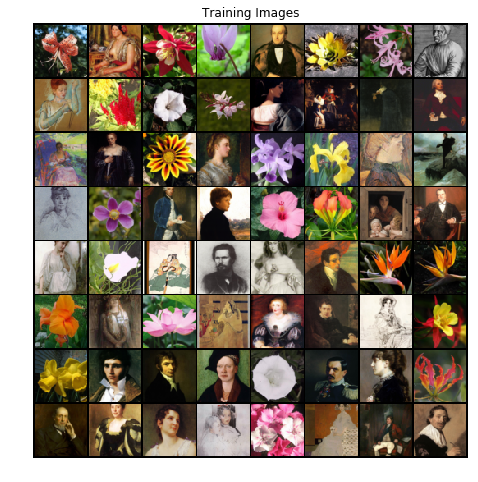

In [7]:
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
#DEVICE = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch,labels = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:

def normal_init(m, mean=0., std=0.5):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        #m.bias.data.zero_()
print(len(dataloader.dataset))     

22000


In [9]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf,4,2,1,bias=False)
        
        # first parameter is number of classes, condition_size is the same as number of classes
        self.convlabel = nn.Conv2d(condition_size, ndf,4,2,1,bias=False)
        
        self.conv2 = nn.Conv2d(ndf * 2,ndf * 4, 4, 2, 1, bias = False)
        self.bn1 = nn.BatchNorm2d(ndf * 4)
        self.conv3 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 8)
        self.conv4 = nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 16)
        self.conv5 = nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)

        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.out = nn.Sigmoid()
        #self.init_weights()
        self.weight_init(mean=0.,std=0.02)
        
    def weight_init(self, mean=0., std=0.02):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
                
    
    def forward(self, x, y=None):
        
        x = self.act(self.conv1(x))
        y = self.act(self.convlabel(y))
        x = torch.cat([x,y],1)
        x = self.act(self.bn1(self.conv2(x)))
        x = self.act(self.bn2(self.conv3(x)))
        x = self.act(self.bn3(self.conv4(x)))
        x = self.conv5(x)
        return self.out(x)

In [10]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size = 100, condition_size=10):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(input_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        
        
        # first parameter is number of classes
        self.convlabel = nn.ConvTranspose2d(condition_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1_1 = nn.BatchNorm2d(ngf * 8)
        
        self.act = nn.LeakyReLU(0.2,inplace=True)
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16,ngf * 8, 4, 2, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias = False)
        self.out = nn.Tanh()
        self.weight_init()
    
    def weight_init(self, mean=0., std=0.02):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, y):
        
        x = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn1_1(self.convlabel(y)))
        x = torch.cat([x,y],1)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        
        return self.out(x)

In [11]:
D = Discriminator(condition_size = num_labels).to(DEVICE)
G = Generator(condition_size=num_labels).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

# Initialize discriminator and Generator weights
#D.apply(weight_init)
#G.apply(weight_init)


# Setup Adam optimizers for both G and D
D_opt = torch.optim.Adam(D.parameters(), lr=0.0005, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999))

print(ngf*8)

512


In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn((batch_size, 100, 1, 1))
fixed_noise = Variable(fixed_noise.to(DEVICE))




In [13]:
# Initialize stuff before training
step = 0
n_critic = 2 # for training more k steps about Discriminator
n_noise = 100
#path1 = F"/content/gdrive/My Drive/Colab Notebooks/Fakes"  


In [14]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

for i in range(len(D_labels)):
    D_labels[i] = torch.add(D_labels[i],np.random.uniform(-0.1,0.1,1)[0])
    D_fakes[i] = torch.add(D_fakes[i],np.random.uniform(0,0.2,1)[0])
print(D_labels.shape)
print(D_fakes.shape)
print(D_labels)

torch.Size([100, 1])
torch.Size([100, 1])
tensor([[1.0086],
        [0.9975],
        [0.9148],
        [0.9257],
        [1.0453],
        [1.0914],
        [0.9984],
        [0.9082],
        [0.9083],
        [1.0617],
        [0.9753],
        [0.9888],
        [1.0199],
        [0.9334],
        [0.9802],
        [1.0285],
        [1.0167],
        [0.9658],
        [1.0632],
        [1.0640],
        [1.0879],
        [0.9541],
        [0.9579],
        [1.0106],
        [1.0663],
        [0.9343],
        [1.0603],
        [1.0152],
        [0.9206],
        [0.9718],
        [1.0092],
        [0.9415],
        [1.0691],
        [1.0387],
        [0.9442],
        [1.0734],
        [1.0124],
        [0.9380],
        [0.9947],
        [1.0013],
        [0.9491],
        [0.9285],
        [1.0815],
        [0.9543],
        [1.0306],
        [1.0009],
        [0.9640],
        [0.9497],
        [1.0503],
        [1.0361],
        [0.9961],
        [1.0856],
        [0.9595],
    

[0/800][0]	Loss_D: 1.6777	Loss_G: 16.7265	D(x): 0.6134	D(G(z)): 0.6652 / 0.0000
[0/800][20]	Loss_D: 0.3936	Loss_G: 5.2963	D(x): 0.9882	D(G(z)): 0.0319 / 0.0075
[0/800][40]	Loss_D: 0.4915	Loss_G: 3.5757	D(x): 0.9934	D(G(z)): 0.2167 / 0.0920
[0/800][60]	Loss_D: 1.8313	Loss_G: 5.3862	D(x): 0.5111	D(G(z)): 0.0005 / 0.0065
[0/800][80]	Loss_D: 0.4618	Loss_G: 4.4291	D(x): 0.9687	D(G(z)): 0.0303 / 0.0779
[0/800][100]	Loss_D: 0.7182	Loss_G: 4.5026	D(x): 0.9758	D(G(z)): 0.3905 / 0.0415
[0/800][120]	Loss_D: 0.5616	Loss_G: 1.5657	D(x): 0.8126	D(G(z)): 0.0751 / 0.2798
[0/800][140]	Loss_D: 0.5294	Loss_G: 2.6802	D(x): 0.8708	D(G(z)): 0.0568 / 0.0747
[0/800][160]	Loss_D: 1.1471	Loss_G: 1.3313	D(x): 0.9218	D(G(z)): 0.6507 / 0.2961
[0/800][180]	Loss_D: 0.4069	Loss_G: 2.4653	D(x): 0.9213	D(G(z)): 0.1094 / 0.0950
[0/800][200]	Loss_D: 0.7421	Loss_G: 2.0035	D(x): 0.7610	D(G(z)): 0.0707 / 0.1562
Figure number:  1


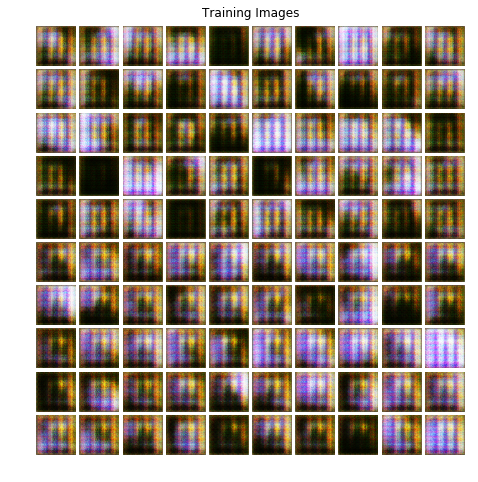

[1/800][220]	Loss_D: 0.7688	Loss_G: 3.9213	D(x): 0.8669	D(G(z)): 0.2667 / 0.0462
[1/800][240]	Loss_D: 0.4881	Loss_G: 2.1728	D(x): 0.8730	D(G(z)): 0.0593 / 0.1408
[1/800][260]	Loss_D: 0.4553	Loss_G: 2.6415	D(x): 0.9430	D(G(z)): 0.1776 / 0.0880
[1/800][280]	Loss_D: 0.4337	Loss_G: 3.2251	D(x): 0.9484	D(G(z)): 0.2031 / 0.0495
[1/800][300]	Loss_D: 0.6489	Loss_G: 1.6462	D(x): 0.8918	D(G(z)): 0.2680 / 0.2997
[1/800][320]	Loss_D: 0.4118	Loss_G: 2.3186	D(x): 0.9508	D(G(z)): 0.1645 / 0.1289
[1/800][340]	Loss_D: 0.7113	Loss_G: 3.3026	D(x): 0.9826	D(G(z)): 0.3938 / 0.0532
[1/800][360]	Loss_D: 0.3511	Loss_G: 2.8186	D(x): 0.9846	D(G(z)): 0.0791 / 0.0686
[1/800][380]	Loss_D: 0.3337	Loss_G: 3.0543	D(x): 0.9944	D(G(z)): 0.0899 / 0.0572
[1/800][400]	Loss_D: 0.4066	Loss_G: 2.4338	D(x): 0.9616	D(G(z)): 0.1959 / 0.0954
[1/800][420]	Loss_D: 0.4414	Loss_G: 2.8370	D(x): 0.8984	D(G(z)): 0.1152 / 0.0686
[2/800][440]	Loss_D: 0.3860	Loss_G: 1.3678	D(x): 0.9596	D(G(z)): 0.0526 / 0.2933
[2/800][460]	Loss_D: 0.3723	

[10/800][2240]	Loss_D: 0.3658	Loss_G: 2.4813	D(x): 0.9697	D(G(z)): 0.1130 / 0.0950
[10/800][2260]	Loss_D: 0.5172	Loss_G: 2.4366	D(x): 0.8158	D(G(z)): 0.0787 / 0.0924
[10/800][2280]	Loss_D: 0.3217	Loss_G: 3.6246	D(x): 0.9986	D(G(z)): 0.0936 / 0.0313
[10/800][2300]	Loss_D: 0.9286	Loss_G: 1.8668	D(x): 0.9616	D(G(z)): 0.5674 / 0.1652
[10/800][2320]	Loss_D: 2.6901	Loss_G: 1.4545	D(x): 0.9339	D(G(z)): 0.9352 / 0.2424
[10/800][2340]	Loss_D: 0.4697	Loss_G: 2.3393	D(x): 0.9252	D(G(z)): 0.2330 / 0.1002
[10/800][2360]	Loss_D: 0.3445	Loss_G: 0.7038	D(x): 0.9760	D(G(z)): 0.0892 / 0.5042
[10/800][2380]	Loss_D: 0.4357	Loss_G: 2.1132	D(x): 0.8957	D(G(z)): 0.0739 / 0.1444
[10/800][2400]	Loss_D: 2.1085	Loss_G: 1.7053	D(x): 0.2396	D(G(z)): 0.3690 / 0.1941
Figure number:  11


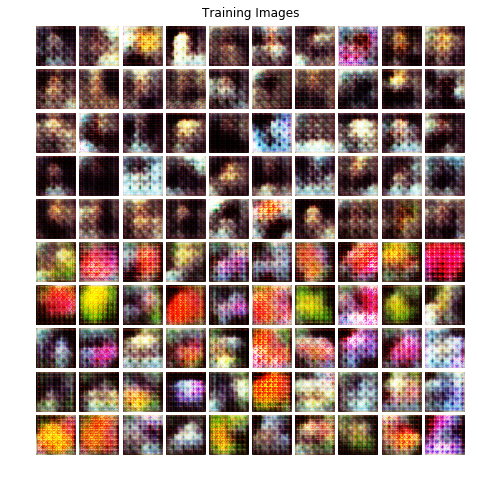

[11/800][2420]	Loss_D: 0.3531	Loss_G: 1.6758	D(x): 0.9786	D(G(z)): 0.0510 / 0.1945
[11/800][2440]	Loss_D: 1.1653	Loss_G: 1.0663	D(x): 0.9937	D(G(z)): 0.6909 / 0.3582
[11/800][2460]	Loss_D: 0.6658	Loss_G: 0.8743	D(x): 0.7314	D(G(z)): 0.1759 / 0.4277
[11/800][2480]	Loss_D: 0.3502	Loss_G: 2.6057	D(x): 0.9964	D(G(z)): 0.0396 / 0.0928
[11/800][2500]	Loss_D: 0.3551	Loss_G: 4.6250	D(x): 0.9678	D(G(z)): 0.0765 / 0.0112
[11/800][2520]	Loss_D: 0.3962	Loss_G: 1.5745	D(x): 0.9813	D(G(z)): 0.2262 / 0.2158
[11/800][2540]	Loss_D: 2.2966	Loss_G: 0.6427	D(x): 0.9745	D(G(z)): 0.9028 / 0.5375
[11/800][2560]	Loss_D: 0.3829	Loss_G: 4.3179	D(x): 0.9469	D(G(z)): 0.0646 / 0.0142
[11/800][2580]	Loss_D: 0.4808	Loss_G: 2.1998	D(x): 0.8600	D(G(z)): 0.1328 / 0.1191
[11/800][2600]	Loss_D: 0.3651	Loss_G: 2.8271	D(x): 0.9784	D(G(z)): 0.1631 / 0.0735
[11/800][2620]	Loss_D: 0.5099	Loss_G: 2.4731	D(x): 0.8512	D(G(z)): 0.1620 / 0.0910
[12/800][2640]	Loss_D: 0.5299	Loss_G: 2.9746	D(x): 0.8153	D(G(z)): 0.1465 / 0.0544
[12/

[20/800][4400]	Loss_D: 0.3179	Loss_G: 3.3241	D(x): 0.9940	D(G(z)): 0.0810 / 0.0373
[20/800][4420]	Loss_D: 0.3979	Loss_G: 3.7337	D(x): 0.9729	D(G(z)): 0.0260 / 0.0252
[20/800][4440]	Loss_D: 0.4228	Loss_G: 1.4586	D(x): 0.8988	D(G(z)): 0.1198 / 0.2426
[20/800][4460]	Loss_D: 1.4503	Loss_G: 3.3058	D(x): 0.9598	D(G(z)): 0.7659 / 0.0391
[20/800][4480]	Loss_D: 0.4095	Loss_G: 4.5448	D(x): 0.9915	D(G(z)): 0.0177 / 0.0119
[20/800][4500]	Loss_D: 0.7768	Loss_G: 3.6407	D(x): 0.9927	D(G(z)): 0.5216 / 0.0294
[20/800][4520]	Loss_D: 0.4131	Loss_G: 1.8653	D(x): 0.9209	D(G(z)): 0.0507 / 0.1664
[20/800][4540]	Loss_D: 0.3412	Loss_G: 2.1149	D(x): 0.9674	D(G(z)): 0.0879 / 0.1370
[20/800][4560]	Loss_D: 2.5254	Loss_G: 2.7706	D(x): 0.1303	D(G(z)): 0.0115 / 0.0774
[20/800][4580]	Loss_D: 0.3305	Loss_G: 0.2657	D(x): 0.9978	D(G(z)): 0.1164 / 0.7724
[20/800][4600]	Loss_D: 1.2174	Loss_G: 2.7535	D(x): 0.4261	D(G(z)): 0.0498 / 0.0669
Figure number:  21


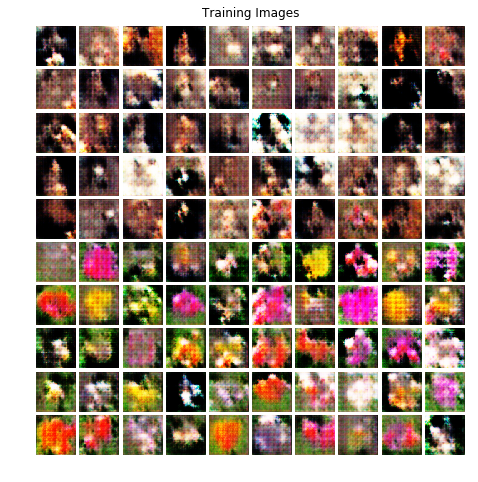

[21/800][4620]	Loss_D: 0.3527	Loss_G: 3.3133	D(x): 0.9574	D(G(z)): 0.0828 / 0.0407
[21/800][4640]	Loss_D: 0.4802	Loss_G: 4.2234	D(x): 0.9884	D(G(z)): 0.3028 / 0.0172
[21/800][4660]	Loss_D: 0.5314	Loss_G: 1.0976	D(x): 0.8068	D(G(z)): 0.0836 / 0.3458
[21/800][4680]	Loss_D: 0.4237	Loss_G: 1.1432	D(x): 0.8993	D(G(z)): 0.0898 / 0.3336
[21/800][4700]	Loss_D: 0.4155	Loss_G: 2.9340	D(x): 0.9129	D(G(z)): 0.0658 / 0.0566
[21/800][4720]	Loss_D: 0.5888	Loss_G: 2.1105	D(x): 0.8089	D(G(z)): 0.2102 / 0.1279
[21/800][4740]	Loss_D: 0.7219	Loss_G: 1.5061	D(x): 0.9703	D(G(z)): 0.4730 / 0.2434
[21/800][4760]	Loss_D: 0.7117	Loss_G: 2.9286	D(x): 0.9930	D(G(z)): 0.4906 / 0.0566
[21/800][4780]	Loss_D: 1.0126	Loss_G: 1.9610	D(x): 0.5327	D(G(z)): 0.2069 / 0.1490
[21/800][4800]	Loss_D: 0.6880	Loss_G: 4.1491	D(x): 0.7719	D(G(z)): 0.0139 / 0.0173
[21/800][4820]	Loss_D: 0.4702	Loss_G: 2.1403	D(x): 0.9653	D(G(z)): 0.2707 / 0.1362
[22/800][4840]	Loss_D: 0.3368	Loss_G: 1.6975	D(x): 0.9924	D(G(z)): 0.0501 / 0.1941
[22/

[30/800][6600]	Loss_D: 0.3340	Loss_G: 2.5864	D(x): 0.9949	D(G(z)): 0.0841 / 0.0826
[30/800][6620]	Loss_D: 0.4436	Loss_G: 1.1776	D(x): 0.9155	D(G(z)): 0.1890 / 0.3218
[30/800][6640]	Loss_D: 2.9754	Loss_G: 0.8986	D(x): 0.9862	D(G(z)): 0.9555 / 0.4215
[30/800][6660]	Loss_D: 0.4586	Loss_G: 3.7474	D(x): 0.9976	D(G(z)): 0.3041 / 0.0247
[30/800][6680]	Loss_D: 1.3280	Loss_G: 2.8173	D(x): 0.3802	D(G(z)): 0.0763 / 0.0636
[30/800][6700]	Loss_D: 0.3738	Loss_G: 3.0719	D(x): 0.9827	D(G(z)): 0.0329 / 0.0492
[30/800][6720]	Loss_D: 0.4733	Loss_G: 1.6193	D(x): 0.8994	D(G(z)): 0.2092 / 0.2075
[30/800][6740]	Loss_D: 0.3457	Loss_G: 2.8690	D(x): 0.9751	D(G(z)): 0.1468 / 0.0596
[30/800][6760]	Loss_D: 0.9309	Loss_G: 1.8429	D(x): 0.9983	D(G(z)): 0.5895 / 0.1660
[30/800][6780]	Loss_D: 0.8643	Loss_G: 1.6387	D(x): 0.5895	D(G(z)): 0.1094 / 0.2054
[30/800][6800]	Loss_D: 0.4502	Loss_G: 2.7394	D(x): 0.8782	D(G(z)): 0.0660 / 0.0700
Figure number:  31


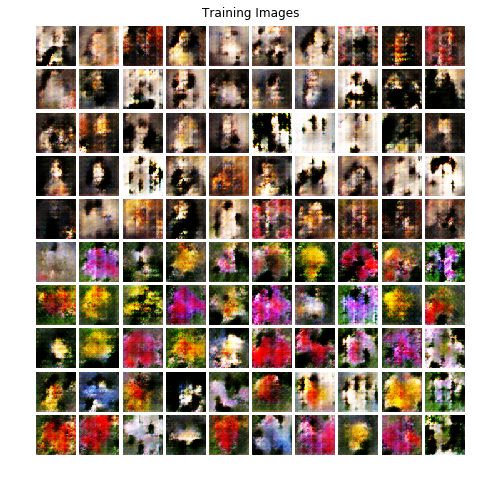

[31/800][6820]	Loss_D: 0.4566	Loss_G: 1.9098	D(x): 0.9803	D(G(z)): 0.2589 / 0.1682
[31/800][6840]	Loss_D: 0.3785	Loss_G: 2.9077	D(x): 0.9680	D(G(z)): 0.0332 / 0.0587
[31/800][6860]	Loss_D: 0.3681	Loss_G: 0.2311	D(x): 0.9408	D(G(z)): 0.0861 / 0.7988
[31/800][6880]	Loss_D: 1.2971	Loss_G: 0.9600	D(x): 0.9993	D(G(z)): 0.7304 / 0.3956
[31/800][6900]	Loss_D: 0.3431	Loss_G: 1.3521	D(x): 0.9842	D(G(z)): 0.0532 / 0.2692
[31/800][6920]	Loss_D: 0.4017	Loss_G: 4.1776	D(x): 0.9871	D(G(z)): 0.0191 / 0.0159
[31/800][6940]	Loss_D: 0.3202	Loss_G: 2.5921	D(x): 0.9955	D(G(z)): 0.1154 / 0.0811
[31/800][6960]	Loss_D: 0.3667	Loss_G: 0.7498	D(x): 0.9958	D(G(z)): 0.1981 / 0.4828
[31/800][6980]	Loss_D: 2.2605	Loss_G: 0.8714	D(x): 0.9947	D(G(z)): 0.9039 / 0.4292
[31/800][7000]	Loss_D: 0.3490	Loss_G: 0.5770	D(x): 0.9964	D(G(z)): 0.1706 / 0.5722
[31/800][7020]	Loss_D: 0.3791	Loss_G: 3.2344	D(x): 0.9978	D(G(z)): 0.0254 / 0.0449
[32/800][7040]	Loss_D: 0.3898	Loss_G: 3.3741	D(x): 0.9340	D(G(z)): 0.0559 / 0.0363
[32/

In [ ]:
# Training loop
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create arrays for Generator and Discriminator losses
G_losses = []
D_losses = []
img_list = []

fixed_y = torch.zeros(num_labels, 1)
y_label = torch.zeros(batch_size, num_labels)

# Creates onehot array, that is diagonal matrix in tensor from.
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)

# Creates fill that makes image size layer with ones for each label
fill = torch.zeros([num_labels, num_labels, image_size, image_size]).to(DEVICE)
for i in range(num_labels):
    fill[i, i, :, :] = 1



# Fixed Y labels for evaluation
y_0 = torch.full((batch_size//num_labels, 1), 0).type(torch.LongTensor).squeeze()
y_fixed_labels = torch.zeros(batch_size, num_labels)

for i in range(1,num_labels):
    desired_label = i
    y_fixed = torch.full((batch_size//num_labels, 1), desired_label).type(torch.LongTensor).squeeze()

    y_0 = torch.cat((y_0, y_fixed), 0)

y_fixed_labels = onehot[y_0]
y_fixed_labels= Variable(y_fixed_labels.cuda())


for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(dataloader):

        # Training Discriminator
        D.zero_grad()
        # Use print(labels.shape) to check how large batch size should be
        #print(labels.shape)
        
        
        y_fill = fill[labels]
        
        x = images.to(DEVICE)
        y = y_fill
        x_outputs = D(x, y)
        x_outputs = x_outputs.view(-1,1)
        D_x = x_outputs.mean().item() # D(x|c) for real data
        D_x_loss = criterion(x_outputs, D_labels)
        
        # Fake data:
        
        z = torch.randn((batch_size, 100, 1, 1))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_fill = fill[y_rand]
        z = Variable(z.to(DEVICE))
        y_label = Variable(y_label.to(DEVICE))
        y_fill =  Variable(y_fill.to(DEVICE))
        
        fake_images = G(z, y_label)
        
        fake_outputs = D(fake_images, y_fill)
        fake_outputs = fake_outputs.view(-1,1)
        D_g_z1 = fake_outputs.mean().item() # D(G(z|c)|c) for fake data
        D_z_loss = criterion(fake_outputs, D_fakes)
         
        D_loss = D_x_loss + D_z_loss
        
        
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            G.zero_grad()
            z = torch.randn((batch_size, 100, 1, 1))
            y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
            y_label = onehot[y_rand]
            y_fill = fill[y_rand]
            z = Variable(z.to(DEVICE))
            y_label = Variable(y_label.to(DEVICE))
            y_fill =  Variable(y_fill.to(DEVICE))
            
            fake_images = G(z,y_label)
            
            fake_outputs = D(fake_images, y_fill)
            D_g_z2 = fake_outputs.mean().item() # D(G(z|c)|c) for fake data
            fake_outputs = fake_outputs.view(-1,1)
            G_loss = criterion(fake_outputs, D_labels)
            
            G_loss.backward()
            G_opt.step()       
        if step % 20 == 0:
            #print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            # Output training stats
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, max_epoch, step,
                     D_loss.item(), G_loss.item(), D_x, D_g_z1, D_g_z2))

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            
        step += 1
        
    if (epoch % 10 == 0):
        print("Figure number: ", epoch+1)
        # generation to image
        G.eval()

        # Create labels from 0 to 9 (tensor is 100 long)
       
        # save image
        
        #torch.save(netG.state_dict(), os.path.join(path2, 'G--{}.ckpt'.format(epoch+1)))
        #torch.save(netD.state_dict(), os.path.join(path3, 'D--{}.ckpt'.format(epoch+1)))
        with torch.no_grad():
            fake_images = G(fixed_noise,y_fixed_labels).detach().cpu()
        #vutils.make_grid(fake_images,padding=2,normalize = True)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
        plt.show()  
        
        img_list.append(vutils.make_grid(fake_images, padding=2, nrow = 10, normalize=True))
        vutils.save_image((fake_images.data), os.path.join(path1, 'fake_images-{}.png'.format(epoch+1)), nrow = 10, normalize=True)
        
        G.train()   

In [ ]:
# Plot losses

#Labels of Cifar-10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# generation to image
G.eval()

# put here the desired label you want to be seen
desired_label = 0

y_rand = torch.full((batch_size, 1), desired_label).type(torch.LongTensor).squeeze()
y_label = onehot[y_rand]
#y_label = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
z = Variable(z.cuda())
y_label = Variable(y_label.cuda())


# Generate images using fixed noise and specific labels. For example "generate fake landscape images"
with torch.no_grad():
    fake_images = G(fixed_noise,y_label).detach().cpu()


    

# Plot figures of specific labels    
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[:64], padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))


# Plot each image separately.

#print(fake_images[0][0].shape)
#for i in range(20):
 #   plt.imshow(fake_images[i][0])
  #  plt.show()

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')

In [ ]:
## 2 Kuvan interpolointi:
# Fake_images on 100 kuvan batch, sieltä pitää valita 2 kuvaa samasta classista
# indeksit niiden mukaan

flatted1 = fake_images[92].view(-1)
flatted2 = fake_images[60].view(-1)

interpolations = np.linspace(flatted1[:],flatted2[:],9)
#print(interpolations.shape)
plt.figure(1,figsize=(25,30))

for i in range(interpolations.shape[0]):
    plt.subplot(191+i) # plottauksen ja muun vois varmaan tehdä järkevämminkin...
    fig1 = torch.tensor(interpolations[i,:])
    fig1 = fig1.view(-1,64,64)
    plt.imshow(np.transpose(vutils.make_grid(fig1.to(DEVICE), normalize=True).cpu(),(1,2,0)))
    plt.axis("off")


In [ ]:
import scipy.spatial.distance as scp

Kuva_nmro = 92
flatted = fake_images[Kuva_nmro].view(1,-1) # Tähän kuva mille etitään vastaavanlaista

N = 10000 # Kuvien määrä siinä classissa mistä haetaan, pitää määritellä dataset uudestaan

dataloader = torch.utils.data.DataLoader(dataset, batch_size = N, shuffle=True)
real_batch = next(iter(dataloader))

images = real_batch[0] # Tähän kaikki datasetin kuvat


flat = torch.zeros(N,3*64*64)
for i in range(N):
    flat[i] = images[i].view(-1) # litistetään kuvat

#print(flat.shape)
#flatted = torch.cat([flatted,flat],0)
#print(flatted.shape)
dist1 = scp.cdist(flatted,flat,'cityblock') # Cityblock pitäisi olla L1 etäisyys

#Y = scp.squareform(scp.pdist(flatted,'cityblock')) 
#dist = scp.pdist(flatted,'cityblock')[0:N]
Ymin = np.min(dist1) # Etsitään pienin etäisyys (= samanlaisin kuva)
print(Ymin)
indx = np.where(dist1==Ymin) # Etsitään sen kuvan indeksi
print(np.where(dist1==Ymin)) 


#Y = scp.cdist(flatted,flat)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[Kuva_nmro],nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[indx[1]],nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()